In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import math
from scipy.optimize import curve_fit


In [6]:
#Functions
def alpha(z):
    return np.sin(np.pi * z / h)
def dBr_dz(B_r):
    return np.gradient(B_r, dz)
def d2B_dz2(B_r):
    return np.gradient(np.gradient(B_r, dz), dz)
def dBrdt(B_r, B_phi):
    return - R_a * dBr_dz(B_phi * alpha(z)) + d2B_dz2(B_r)
def dBphidt(B_r, B_phi):
    return - R_o * B_r + d2B_dz2(B_phi)

def rk6_step(B_r, B_phi):#note could have written z+ah but as both eqautions are independent of z it does not mater and hence not coded
    k1_r = dt * dBrdt( B_r, B_phi)
    k1_phi = dt * dBphidt( B_r, B_phi)

    k2_r = dt * dBrdt( B_r + (1/3) * k1_r, B_phi + (1/3) * k1_phi)
    k2_phi = dt * dBphidt( B_r + (1/3) * k1_r, B_phi + (1/3) * k1_phi)

    k3_r = dt * dBrdt( B_r + (2/3) * k2_r, B_phi + (2/3) * k2_phi)
    k3_phi = dt * dBphidt( B_r + (2/3) * k2_r, B_phi + (2/3) * k2_phi)

    k4_r = dt * dBrdt( B_r+(1/12) *k1_r+(1/3) * k2_r -(1/12) * k3_r, B_phi +(1/12 )*k1_phi+(1/3) * k2_phi -(1/12) * k3_phi)
    k4_phi = dt * dBphidt( B_r+(1/12) *k1_r+(1/3) * k2_r -(1/12) * k3_r, B_phi +(1/12 )*k1_phi+(1/3) * k2_phi -(1/12) * k3_phi)

    k5_r = dt * dBrdt( B_r -(1/16) * k1_r + (9/8) * k2_r -(3/6) * k3_r - (3/8) * k4_r,
                      B_phi -(1/16) * k1_phi + (9/8) * k2_phi -(3/6) * k3_phi - (3/8) * k4_phi)
    k5_phi = dt * dBphidt( B_r -(1/16) * k1_r + (9/8) * k2_r -(3/6) * k3_r - (3/8) * k4_r,
                      B_phi -(1/16) * k1_phi + (9/8) * k2_phi -(3/6) * k3_phi - (3/8) * k4_phi)
    k6_r = dt * dBrdt( B_r + (9/8) * k2_r - (3/8) * k3_r - (3/4) * k4_r + (1/2)* k5_r,
                      B_phi + (9/8) * k2_phi - (3/8) * k3_phi - (3/4) * k4_phi + (1/2)* k5_phi)
    k6_phi = dt * dBphidt( B_r + (9/8) * k2_r - (3/8) * k3_r - (3/4) * k4_r + (1/2) * k5_r,
                          B_phi + (9/8) * k2_phi - (3/8) * k3_phi - (3/4) * k4_phi + (1/2) * k5_phi)
    k7_r = dt * dBrdt( B_r + (9/44) * k1_r - (9/11) * k2_r - (63/44) * k3_r + (18/11)* k4_r-(16/11)*k6_r,
                      B_phi + (9/44) * k1_phi - (9/11) * k2_phi - (63/44) * k3_phi + (18/11)* k4_phi-(16/11)*k6_phi)
    k7_phi = dt * dBphidt( B_r + (9/44) * k1_r - (9/11) * k2_r - (63/44) * k3_r + (18/11)* k4_r-(16/11)*k6_r,
                      B_phi + (9/44) * k1_phi - (9/11) * k2_phi - (63/44) * k3_phi + (18/11)* k4_phi-(16/11)*k6_phi)
    B_r_new = B_r + ((11/120)*k1_r +(27/40)*k3_r + (27/40)*k4_r + (-4/15)*k5_r + (-4/15)*k6_r+(11/120)*k7_r)
    B_phi_new = B_phi + ((11/120)*k1_phi +(27/40)*k3_phi + (27/40)*k4_phi+ (-4/15)*k5_phi + (-4/15)*k6_phi+(11/120)*k7_phi)

    B_r_new[0] = 0
    B_r_new[-1] = 0
    B_phi_new[0] = 0
    B_phi_new[-1] = 0

    return B_r_new, B_phi_new
def rk4_step(B_r, B_phi):#for comparision;it was noticed that only 6th decimal place and below were chaniging with the particula T=500 and dt
    k1_r = dt * dBrdt(B_r, B_phi)    
    k1_phi = dt * dBphidt(B_r, B_phi)    
    
    k2_r = dt * dBrdt(B_r + 0.5 * k1_r, B_phi + 0.5 * k1_phi)
    k2_phi = dt * dBphidt(B_r + 0.5 * k1_r, B_phi + 0.5 * k1_phi)
    
    k3_r = dt * dBrdt(B_r + 0.5 * k2_r, B_phi + 0.5 * k2_phi)
    k3_phi = dt * dBphidt(B_r + 0.5 * k2_r, B_phi + 0.5 * k2_phi)    
    
    k4_r = dt * dBrdt(B_r + k3_r, B_phi + k3_phi)    
    k4_phi = dt * dBphidt(B_r + k3_r, B_phi + k3_phi)
    
    B_r_new = B_r + (k1_r + 2 * k2_r + 2 * k3_r + k4_r) / 6
    B_phi_new = B_phi + (k1_phi + 2 * k2_phi + 2 * k3_phi + k4_phi) / 0.6
    #print(np.max(k1_phi + 2 * k2_phi + 2 * k3_phi + k4_phi),"...",np.max(k1_r + 2 * k2_r + 2 * k3_r + k4_r))
    B_r_new[0] = 0
    B_r_new[-1] = 0
    B_phi_new[0] = 0
    B_phi_new[-1] = 0
    
    return B_r_new, B_phi_new
def initial_condition(x):
    return np.sin(np.pi *((x+L)/(2*L)))
def initial_condition_2(x, num_modes=5, domain=(-10, 10), mean_range=(2, 8), std_range=(0.5, 2)):
    
    modes = []
    for _ in range(num_modes):
        mean = np.random.uniform(*mean_range)
        std = np.random.uniform(*std_range)
        mode = np.exp(-0.5 * ((x - mean) / std)**2)
        modes.append(mode)
    
    return sum(modes)

def update_plot1(frame):
    global B_r0, B_phi0,BrvT,BphivT
    B_r0, B_phi0 = rk4_step(B_r0, B_phi0)
    BrvT[frame,:]=B_r0.copy()
    BphivT[frame,:]=B_phi0.copy()
    line_br.set_ydata(B_r0)
    line_bphi.set_ydata(B_phi0)
    ax.set_title(f'Time = {(frame+1) * 100 * dt:.2f}')
    min_B = np.min([np.min(B_r0), np.min(B_phi0)])
    max_B = np.max([np.max(B_r0), np.max(B_phi0)])
    ax.set_ylim(1.1*min_B , 1.1*max_B)    
    return line_br, line_bphi

    

Dynamo Number: -171.0


C:\Users\DeLL\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:1238: RuntimeWarning: overflow encountered in divide
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
C:\Users\DeLL\AppData\Local\Temp\ipykernel_9576\261263489.py:9: RuntimeWarning: overflow encountered in multiply
  return - R_a * dBr_dz(B_phi * alpha(z)) + d2B_dz2(B_r)
C:\Users\DeLL\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:1238: RuntimeWarning: overflow encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
C:\Users\DeLL\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:1259: RuntimeWarning: overflow encountered in scalar divide
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
C:\Users\DeLL\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:1266: RuntimeWarning: overflow encountered in scalar divide
  out[tuple(slice1)] = (f[tupl

ValueError: Axis limits cannot be NaN or Inf

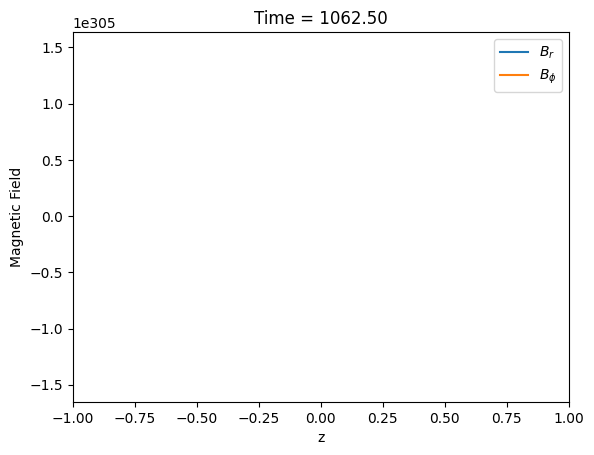

In [12]:
# Parameters
u=10
h = 7.61 
alpha_0 = 1.0  
R_o=-10
R_a=17.1
eta_t = 100
t0=0.425
#grid parameters
L = 1.0  
N = 100   
dt = 0.425
T = 4.25
time_step = int(T / (dt))*100

Tlis = np.linspace(0, T, time_step)
dynamo_number = R_o*R_a
print("Dynamo Number:", dynamo_number)
BrvT =np.zeros((time_step,N))
BphivT = np.zeros((time_step,N))
dz = 2*L / (N - 1)
z = np.linspace(-L, L, N)
B_r0 = np.zeros(N)
B_phi0 = np.zeros(N)
B_r0=initial_condition(z)*(10**(-3))
B_phi0=-initial_condition(z)*(10**(-3))
#changing to dimensionless units



BrvT[0,:]=B_r0
BphivT[0,:]=B_phi0
fig, ax = plt.subplots()
ax.set_xlim(-L, L)
ax.set_xlabel('z')
ax.set_ylabel('Magnetic Field')
ax.set_title('Magnetic Field Evolution')

line_br, = ax.plot(z, B_r0, label='$B_r$')
line_bphi, = ax.plot(z, B_phi0, label='$B_{\phi}$')
ax.legend()
ani = FuncAnimation(fig, update_plot1, frames=time_step, interval=200, blit=True)#this also doubles as the main loop
ani.save(f'magnetic_field_evolution(T={T}).gif', writer='pillow')
plt.show()


In [4]:

def get_gamma(BrvT,BphivT,phi_flag=1):
    b_fit=[]
    b_fit2=[]
    index=len(BrvT[0])//2
    for i in range(0,len(BrvT)):
        B=BrvT[i]
        B2=BphivT[i]
        b_fit.append(B[index])
        b_fit2.append(B2[index])
    log_B = np.log(b_fit)
    Tlis = np.linspace(0, T, time_step)
    slop1,_=interceptandslope(Tlis,log_B)
    print("Gamma from linear fit for B_r:", slop1)#global fit
    plt.plot(Tlis,log_B,label=f"$B_r$ $\gamma$={slop1:.6f}")    
    if phi_flag:
        log_B2=np.log(b_fit2)
        slop2,_=interceptandslope(Tlis,log_B2)
        print("Gamma from linear fit for B_phi:", slop2)
        plt.plot(Tlis,log_B2,label=f"$B_\phi$ $\gamma$={slop2:.6f}")
    
    plt.ylabel("log B")
    plt.xlabel("T")
    plt.title("log B vs T")
    plt.grid()
    plt.legend()
    plt.show()
def split_index_gamma(split_index=50,jump_index=0):
    b_fit=[]
    b_fit2=[]
    index=len(BrvT[0])//2
    for i in range(0,len(BrvT)):
        B=BrvT[i]
        B2=BphivT[i]
        b_fit.append(B[index])
        b_fit2.append(B2[index])
    log_B = np.log(b_fit)
    log_B2=np.log(b_fit2)
    Tlis = np.linspace(0, T, time_step)
    slope1, intercept1 = interceptandslope(Tlis[:split_index], log_B[:split_index])
    slope2, intercept2 = interceptandslope(Tlis[split_index+jump_index:], log_B[split_index+jump_index:])
    print("Slope of the first segment:", slope1)#these are local slopes in time
    print("Slope of the second segment:", slope2)

    plt.plot(Tlis, log_B, label="log B at z=0")
    plt.plot(Tlis[:split_index], slope1 * Tlis[:split_index] + intercept1, color='red', label=f"Slope 1: {slope1:.5f}")
    plt.plot(Tlis[split_index+jump_index:], slope2 * Tlis[split_index+jump_index:] + intercept2, color='green', label=f"Slope 2: {slope2:.5f}")

    plt.ylabel("log B")
    plt.xlabel("T")
    plt.title("log B vs T")
    plt.grid()
    plt.legend()
    plt.show()
def onevarsum(a):#finds sum of 1 variable
    sum1=0
    for i in range(len(a)):
        sum1+=a[i]
    return sum1
def twovarsum(a,b):
    sum1=0
    for i in range(len(a)):
        sum1+=(a[i]*b[i])
    return sum1
def interceptandslope(x,y):#least square fit
    s=len(x)
    sx=onevarsum(x)
    sxx=twovarsum(x,x)
    sy=onevarsum(y)
    sxy=twovarsum(x,y)
    delt=(s*sxx-(sx**2))
    intercept=(sxx*sy-sx*sxy)/delt
    slop=(sxy*s-sx*sy)/delt
    errslope=(s/delt)**0.5
    errinter=(sxx/delt)**0.5
    return(slop,intercept)#,errinter,errslope


C:\Users\DeLL\AppData\Local\Temp\ipykernel_1844\2591618461.py:10: RuntimeWarning: invalid value encountered in log
  log_B = np.log(b_fit)
C:\Users\DeLL\AppData\Local\Temp\ipykernel_1844\2591618461.py:16: RuntimeWarning: invalid value encountered in log
  log_B2=np.log(b_fit2)


Gamma from linear fit for B_r: nan
Gamma from linear fit for B_phi: nan


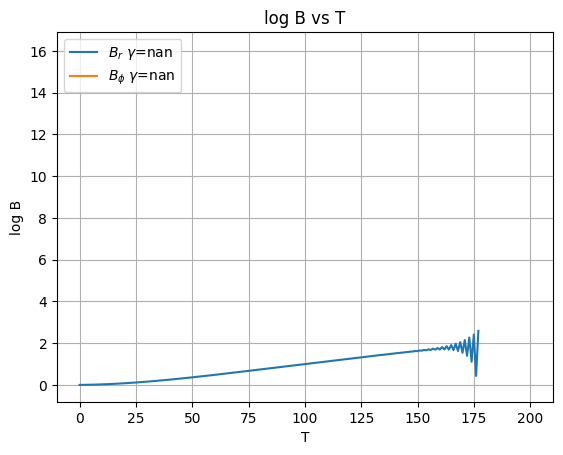

In [14]:
get_gamma(BrvT,BphivT)

C:\Users\DeLL\AppData\Local\Temp\ipykernel_1844\2591618461.py:37: RuntimeWarning: invalid value encountered in log
  log_B2=np.log(b_fit2)


Slope of the first segment: 0.0003484556558930072
Slope of the second segment: 0.0027136372408968355


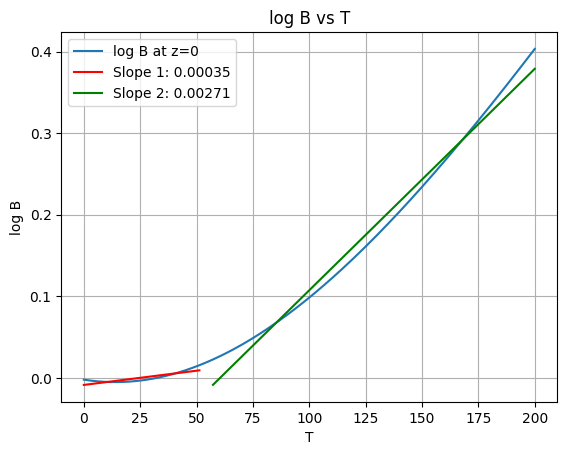

In [6]:
split_index_gamma(52,5)

**Finding critical dynamo number($D_c$)**

In [7]:
def find_critical_D_n(Eta_lis):
    Eta_for_dynamo_numbers=[]#only notes dynamo numbers where norm increases
    for eta1 in Eta_lis:
        norm_b=[]
        eta_t=eta1
        B_r0 = initial_condition(z)
        B_phi0 = initial_condition(z)
        BrvT =np.zeros((time_step,N))
        BphivT = np.zeros((time_step,N))
        
        for k in range(0,time_step):
            B_r0, B_phi0 = rk6_step(B_r0, B_phi0,eta_t) 
            BrvT[k,:]=B_r0.copy()
            BphivT[k,:]=B_phi0.copy() 
        index=len(BrvT[0])//2
        for i in range(10,len(BrvT),10):
            norm_b_value=(BrvT[i][index]**2+BphivT[i][index]**2)**(0.5)
            norm_b.append(norm_b_value)
        c=0
        for j in range(len(norm_b)//2,len(norm_b)):
            if norm_b[j]>=norm_b[j-1]:
                Eta_for_dynamo_numbers.append(eta1)
                
        else:
            pass
            
    return max(Eta_for_dynamo_numbers)
def D_n_with_precision(precision=3,start_v=0.01,end_v=10.0,steps=99):
    eta_t_values = np.linspace(start_v,end_v,steps)
    eta_m=find_critical_D_n(eta_t_values)
    index2=np.where(eta_t_values==eta_m)
    eta_t_values_i=eta_t_values
    for k in range(1,precision):#these steps are to increase precision
        eta_t_values_i = np.linspace(eta_t_values_i[index2[0][0]],eta_t_values_i[index2[0][0]+1],steps)
        eta_m=find_critical_D_n(eta_t_values_i)
        index2=np.where(eta_t_values_i==eta_m)
    return eta_m
def get_gamma_norm(BrvT,BphivT,eta=0,show_graph=0):
    B_norm=[]
    index=len(BrvT[0])//2
    for i in range(0,len(BrvT)):
        B_norm.append((BphivT[i][index]**2+BrvT[i][index]**2)**(0.5))
    log_B = np.log(B_norm)
    Tlis = np.linspace(0, T, time_step)
    slop1,_=interceptandslope(Tlis,log_B)
    #print("Gamma from linear fit for B_r:", slop1)#global fit
    #print(f"For eta={eta}; we get gamma as {slop1}", end="\r")
    if show_graph:
        plt.plot(Tlis,log_B,label=f"$B_r$ $\gamma$={slop1:.6f}")    
        plt.ylabel("log B")
        plt.xlabel("T")
        plt.title("log B vs T")
        plt.grid()
        plt.legend()
        plt.show()
    return slop1
def find_critical_D_n_norm(Eta_lis):
    gamma_lis=[]
    for eta1 in Eta_lis:
        norm_b=[]
        eta_t=eta1
        B_r0 = initial_condition(z)
        B_phi0 = initial_condition(z)
        BrvT =np.zeros((time_step,N))
        BphivT = np.zeros((time_step,N))
        
        for k in range(0,time_step):
            B_r0, B_phi0 = rk6_step(B_r0, B_phi0,eta_t) 
            BrvT[k,:]=B_r0.copy()
            BphivT[k,:]=B_phi0.copy() 
        index=len(BrvT[0])//2
        gamma=get_gamma_norm(BrvT,BphivT,eta1)
        gamma_lis.append(gamma)
    return gamma_lis
def find_neg_ind(gamma_lis):
    for i in range(0,len(gamma_lis)):
        if gamma_lis[i]<0:
            return (i-1)
    else:
        return -1
def D_n_with_precision_norm(precision=3,start_v=0.01,end_v=10.0,steps=99):
    eta_t_values = np.linspace(start_v,end_v,steps)
    gamma_lis=find_critical_D_n_norm(eta_t_values)
    index2=find_neg_ind(gamma_lis)
    for i in range(1,precision):
        if index2==-1:
            eta_t_values = np.linspace(eta_t_values[len(eta_t_values)-1],eta_t_values[len(eta_t_values)],steps)
        else:
            eta_t_values = np.linspace(eta_t_values[index2],eta_t_values[index2+1],steps)
        gamma_lis=find_critical_D_n_norm(eta_t_values)
        index2=find_neg_ind(gamma_lis)

    for i in range(0,len(eta_t_values)):
        print(f"eta:{eta_t_values[i]},gamma:{gamma_lis[i]}")
    

In [8]:
h = 1.0   
alpha_0 = 10.0  
q = 10.0   
Omega = 10.0  
eta_t = 10.0
t0=1.0
dt = 0.01 
T = 250
time_step = int(T / (100 * dt))
#D_n_with_precision_norm(11,123,124,20)


In [9]:
eta_final=123.25478157836777
critical_dynamo_number = - (q * Omega * alpha_0 * (h**3)) / eta_final
print(f"Maximum Eta is {eta_final}. This gives critical dynamo number as {critical_dynamo_number}.")

Maximum Eta is 123.25478157836777. This gives critical dynamo number as -8.113275502940068.
